# SAGE III-ISS L2 Solar Event Species Profiles V053 Plots
##### Code uses a python API library called earthaccess that has spatial and temporal filters to search and download the SAGE product g3bssp_53 then plots the Aerosol Ozone Concentration, the Water Vapor Concentration and the Nitrogen Dioxide Concentration.

### Table of Contents
1. Setup
2. Temporal Search
3. Spatial Search
4. Confirm Temporal and Spatial Filters
5. Download Data
6. Plot Data


### 1. Setup

In [2]:
import earthaccess
import netCDF4 as nc 
import os
import sys
import glob
import numpy as np
import h5py
from pathlib import Path
import pandas as pd
import datetime
import requests
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import Image
from plot import plot_data

home_dir = os.environ['HOME']
sage_profile_dir = os.path.abspath(f"{home_dir}/sage_daily_profiles")
if not os.path.exists(sage_profile_dir):
    os.makedirs(sage_profile_dir)

%reload_ext autoreload
%autoreload 2

### 2. Temporal Search
#### You will prompted to enter either a date or a range of dates to be plotted. Then the daily event coverage map(s) from the SAGE Quicklook Webiste will be displayed of the selected dates. This will help visaulize where the solar events are located when choosing coordinates for the spatial search. 

In [3]:
def input_start_date():
    valid_answer_start = False
    while not valid_answer_start:
        answer_start_date = input('\nPlease enter a start date of interest \nFormat YYYY-MM-DD \n:')
        start_date_format = '%Y-%m-%d'
        try:
            datetime.datetime.strptime(answer_start_date, start_date_format)
        except ValueError:
            print(f'\n{answer_start_date} is an invalid format. \nFormat should be YYYY-MM-DD')
            answer = input('Would you like to try again? (y/n) \n:')
            if answer.lower() == 'n':
                sys.exit()
        else:
            break
    return answer_start_date


def input_end_date():
    valid_answer = False
    while not valid_answer:
        answer_end_date = input('\nPlease enter an end date of interest \nFormat YYYY-MM-DD \n:')
        end_date_format = '%Y-%m-%d'
        try:
            datetime.datetime.strptime(answer_end_date, end_date_format)
        except ValueError:
            print(f'\n{answer_end_date} is an invalid format. \nFormat should be YYYY-MM-DD')
            answer = input('Would you like to try again? (y/n) \n:')
            if answer.lower() == 'n':
                sys.exit()
        else:
            break
    return answer_end_date

def display_images(date_list):
    for date in date_list:
        y = date[:4]
        m = date[5:7]
        d = date[-2:]
        date_comb = date.replace('-', '')
        url = f'https://sage.nasa.gov/sageiii-iss/browse_images/quicklook/SAGEWeb/Quicklook/daily/{y}/{m}/{d}//QL_DAILY_MAP_{date_comb}.jpg'
        display(Image(url=url, height=300))

def get_dates():    
    valid_answer = False
    while not valid_answer:
        answer_one = input('\nHello, please select A or B. \n(A) One Date \n(B) Date Range \n:')
        if answer_one.upper() == 'A':    
            start_date = input_start_date()
            end_date =  start_date
            date_list = pd.period_range(start=start_date, end=end_date, freq='D')
            date_list = [date.strftime("%Y-%m-%d") for date in date_list]        
            break
        elif answer_one.upper() == 'B':       
            start_date = input_start_date()
            end_date = input_end_date()
            date_list = pd.period_range(start=start_date, end=end_date, freq='D')
            date_list = [date.strftime("%Y-%m-%d") for date in date_list]        
            break
    return start_date, end_date, date_list        

dates = get_dates()
start_date = dates[0]
end_date = dates[1]
date_list = dates[2]
display_images(date_list)

### 3. Spatial Search
#### You will be prompted to select a minimum/maximum longitude and latitude values. Once a selected a bounding box with the coordinates of your choosing will be displayed. 

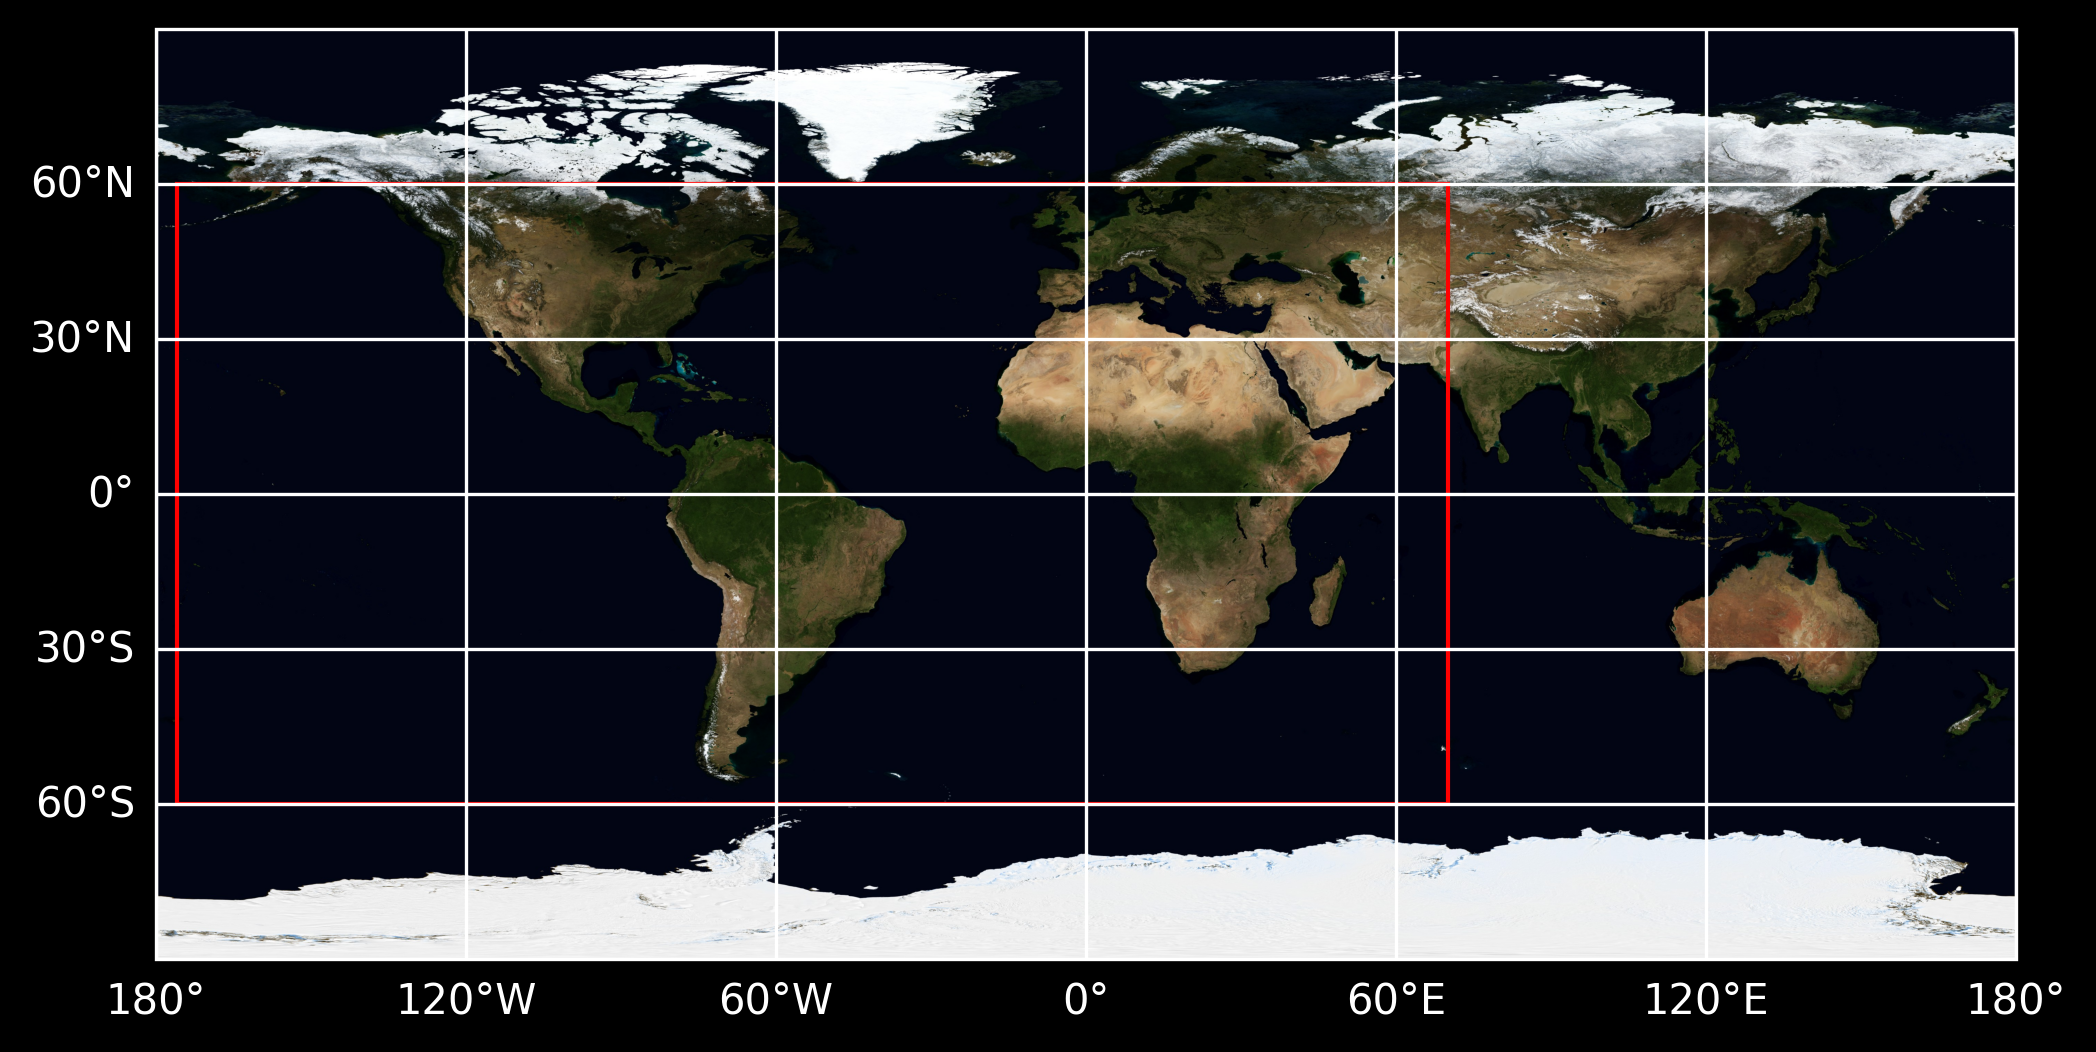

In [5]:
def get_coords():

    valid_answer = False
    while not valid_answer:
        try:
            lon_min = input('Please select min longitude value (-180 to 180):')
            lon_min = int(lon_min)
            if lon_min < -180 or lon_min > 180:
                print('Value not in range. \nPlease select min longitude value (-180 to 180)')
                answer = input('Would you like to try again? (y/n) \n:')
                if answer.lower() == 'n':
                    sys.exit()
        except ValueError:
            print(f'\n{lon_min} not a valid value')
            answer = input('Would you like to try again? (y/n) \n:')
            if answer.lower() == 'n':
                sys.exit()        
        else:
            break

    valid_answer = False
    while not valid_answer:
        try:
            lat_min = input('Please select min latitude value (-75 to 75):')
            lat_min = int(lat_min)
            if lat_min < -75 or lat_min > 75:
                print('Value not in range. \nPlease select min latitude value (-75 to 75):')
                answer = input('Would you like to try again? (y/n) \n:')
                if answer.lower() == 'n':
                    sys.exit()
        except ValueError:
            print(f'\n{lat_min} not a valid value')
            answer = input('Would you like to try again? (y/n) \n:')
            if answer.lower() == 'n':
                sys.exit()        
        else:
            break
        
    valid_answer = False
    while not valid_answer:
        try:
            lon_max = input('Please select max longitude value (-180 to 180):')
            lon_max = int(lon_max)
            if lon_max < -180 or lon_max > 180:
                print('Value not in range. \nPlease select max longitude value (-180 to 180)')
                answer = input('Would you like to try again? (y/n) \n:')
                if answer.lower() == 'n':
                    sys.exit()
        except ValueError:
            print(f'\n{lon_max} not a valid value')
            answer = input('Would you like to try again? (y/n) \n:')
            if answer.lower() == 'n':
                sys.exit()        
        else:
            break

    valid_answer = False
    while not valid_answer:
        try:
            lat_max = input('Please select max latitude value (-75 to 75):')
            lat_max = int(lat_max)
            if lat_max < -75 or lat_max > 75:
                print('Value not in range. \nPlease select max latitude value (-75 to 75):')
                answer = input('Would you like to try again? (y/n) \n:')
                if answer.lower() == 'n':
                    sys.exit()
        except ValueError:
            print(f'\n{lat_min} not a valid value')
            answer = input('Would you like to try again? (y/n) \n:')
            if answer.lower() == 'n':
                sys.exit()        
        else:
            break
    
    return lon_min, lat_min, lon_max, lat_max

coords = get_coords()
lon_min = coords[0]
lat_min = coords[1]
lon_max = coords[2]
lat_max = coords[3]

# Alternatively download and load the image locally
img = plt.imread('world_map.jpg')

fig = plt.figure(figsize=(8, 10), dpi=300)

# Define the image (covers the entire Earth)
img_extent = (-180, 180, -90, 90)
ax = plt.axes(projection=ccrs.PlateCarree())
rect = plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                     transform=ccrs.PlateCarree(), color='red', fill=False)
ax.imshow(img, extent = img_extent ,transform=ccrs.PlateCarree())

# Add the rectangle to the map
ax.add_patch(rect)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_global()
plt.style.use('dark_background')
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
plt.show()

### 4. Confirm Temporal and Spatial Filters
#### Once you have selected you date(s) and coordinates, enter your Earthdata Login credentials when prompted. You will also have the option to make any changes to your temporal and spatial filters. Then earthacess will be used to search for files that fall within the temporal and spatial bounds. 

In [6]:
earthaccess.login()

valid_answer = False
while not valid_answer:
    answer = input(f"This is the date range you selected: \n{start_date} to {end_date} \
    \nWould you like to make a change? \ny/n: ")
    if answer.lower() == 'n':
        break
    elif answer.lower() == 'y':
        dates = get_dates()
        start_date = dates[0]
        end_date = dates[1]
        date_list = dates[2]
        break
    else: 
        print('Sorry did not understand you answer')
        sys.exit()


valid_answer = False
while not valid_answer:
    answer = input(f"These are the coordinates you selected: \nLon Min: {lon_min} \
    \nLat Min: {lat_min} \nLon Max: {lon_max} \nLat Max: {lat_max}  \
    \nWould you like to make a change? \ny/n: ")
    if answer.lower() == 'n':
        break
    elif answer.lower() == 'y':
        coords = get_coords()
        lon_min = coords[0]
        lat_min = coords[1]
        lon_max = coords[2]
        lat_max = coords[3]
        break
    else: 
        print('Sorry did not understand you answer')
        sys.exit()

short_name = 'g3bssp'
version = '53'
collection = short_name + '_' + version
results = earthaccess.search_data(
    short_name= short_name,
    version = version,
    bounding_box=(lon_min, lat_min, lon_max, lat_max),
    temporal=(start_date, end_date),
)

if len(results[:]) > 0:
    print(f'{len(results[:])} files found. \
        \nDate Range: {start_date} to {end_date} \
        \nBounding Box Coordinates: Lon Min: {lon_min}, Lat Min: {lat_min}, Lon Max: {lon_max}, Lat Max: {lat_max}')
elif len(results[:]) == 0:
    print('No files found. \nCheck temporal range and coordinates.')

22 files found.         
Date Range: 2024-08-24 to 2024-08-24         
Bounding Box Coordinates: Lon Min: -176, Lat Min: -60, Lon Max: 70, Lat Max: 60


### 5. Download Data
#### Use earthaccess to download data. 

In [7]:
directory = []
for r in results[:]:
    file = r['umm']['DataGranule']['Identifiers'][0]['Identifier']
    date_time = r['umm']['TemporalExtent']['SingleDateTime']
    index_T = date_time.index('T')
    date = date_time[:index_T]
    
    try:
        os.makedirs(f'{sage_profile_dir}/{collection}/{date}')
    except FileExistsError: 
        continue
    finally:
        if os.path.exists(f'{sage_profile_dir}/{collection}/{date}/{file}') == True:
            print(f'The file, {file} already exists. \nLocated here: ~/sage_daily_profiles/{collection}/{date}')
        else:
            if date_time.find(date) != -1:
                earthaccess.download(r, f'{sage_profile_dir}/{collection}/{date}')    

        directory.append(f'{sage_profile_dir}/{collection}/{date}/*')   
        directory = list(set(directory))

    print(f'Files downloaded for {date} located here: ~/sage_daily_profiles/{collection}/{date}')   

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]


Files downloaded for 2024-08-24 located here: ~/sage_daily_profiles/g3bssp_53/2024-08-24


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2092.97it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 25575.02it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2054.02it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1886.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2101.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
COLLECTING RESULTS | : 100%|██████████| 1/

### Plot Data
#### Plot the Aerosol Ozone Concentration, the Water Vapor Concentration and the Nitrogen Dioxide Concentration. Source for plotting: https://hdfeos.org/zoo/LaRC/g3b.ssp.2022062949SSv05.21.py

In [9]:
file_lists = []
filenames = []
filename = []


for d in directory:
    file_lists.append(glob.glob(d))


for file in file_lists:
    for f in file:
        a = f.split('/')[-1]
        b = a.index('v')
        c = a[:b].rsplit('.')[2]
        filenames.append(c)
    filename.append(filenames)

filename_each_day = []
for i, d in zip(range(len(filename)), sorted(date_list)):
    new_list = [x for x in filename[i] if d.replace('-', '') in x]
    filename_each_day.append(new_list)
        

dates_ss = []
dates_sr = []
ss_lists = []
sr_lists = []


for index, date in zip(range(len(filename_each_day)), sorted(date_list)):
    for i in range(len(filename_each_day[index])):
        if 'SS' in filename_each_day[index][i]:
            if date.replace('-', '') in filename_each_day[index][i]:
                ss_lists.append(filename_each_day[index][i]) 
        elif 'SR' in filename_each_day[index][i]:
            if date.replace('-', '') in filename_each_day[index][i]:
                sr_lists.append(filename_each_day[index][i]) 
    date_ss = [x for x in ss_lists if date.replace('-', '') in x]
    dates_ss.append(date_ss)
    date_sr = [x for x in sr_lists if date.replace('-', '') in x]
    dates_sr.append(date_sr)

dict_ss = {}
dict_sr = {}
for d, d_ss in zip(sorted(date_list), range(len(dates_ss))):
    dict_ss[d] = dates_ss[d_ss]
    
for d, d_sr in zip(sorted(date_list), range(len(dates_sr))):
    dict_sr[d] = dates_sr[d_sr]
    
plot_data(date_list, file_lists, filename_each_day, dict_ss, dict_sr, collection, sage_profile_dir)

Done. Plot for AO3 Concentration on 2024-08-24 located here: ~/sage_daily_profiles/g3bssp_53/2024-08-24
Done. Plot for H2O Concentration on 2024-08-24 located here: ~/sage_daily_profiles/g3bssp_53/2024-08-24
Done. Plot for NO2 Concentration on 2024-08-24 located here: ~/sage_daily_profiles/g3bssp_53/2024-08-24
